### 公立中学校のクラス編成問題

-   【要件1】学年の全生徒をそれぞれ1つのクラスに割り当てる。
-   【要件2】各クラスの人数は39人以上、40人以下とする。　　318人の生徒、8つのクラス。
-   【要件3】各クラスの男子生徒、女子生徒の人数は20人以下とする。　男子生徒158人、女子生徒160人。
-   【要件4】各クラスの学力の平均点は学年平均の$\pm10$点とする。　500点満点で、学年平均303.6点。
-   【要件5】各クラスにリーダー気質の生徒を2人以上割り当てる。　　学年にリーダー気質は17人。
-   【要件6】特別な支援が必要な生徒は各クラスに1人以下とする。　　学年に特別な支援が必要な生徒は4人。
-   【要件7】特定ペアの生徒は同一クラスに割り当てない　　　　　　 学年に特定ペアは3組みいる。

1.データの中身の確認

In [2]:
import pandas as pd

s_df = pd.read_csv("students.csv")
print(f"students.csvの要素数：{len(s_df)}")
s_df.head()

students.csvの要素数：318


,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


次に、カラムに登録されているデータを確認してみる。

In [3]:
s_df["student_id"]

0        1
1        2
2        3
3        4
4        5
      ... 
313    314
314    315
315    316
316    317
317    318
Name: student_id, Length: 318, dtype: int64

In [ ]:
print(s_df["student_id"].max()) # 学籍番号の最大値と最小値の確認
print(s_df["student_id"].min())

318
1


In [ ]:
set(range(1, 319)) == set(s_df["student_id"].tolist()) # 1～318まで隙間なく番号で埋められているか確認
# range(1, 319)で1～318までの整数を作り、set()でそれらを集合にしている。
# 抜けや重複があればFalse が返る

True

genderの中身を確認してみる。value_counts()で、カラム内の各要素（0 or 1）の数をカウントする。

In [6]:
s_df["gender"].value_counts()

gender
0    160
1    158
Name: count, dtype: int64

次に、scoreを確認する。describe()関数で、カラム内の基本的な統計要約を出力する。

In [7]:
s_df["score"].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

学力データをヒストグラムで確認してみる。

<Axes: >

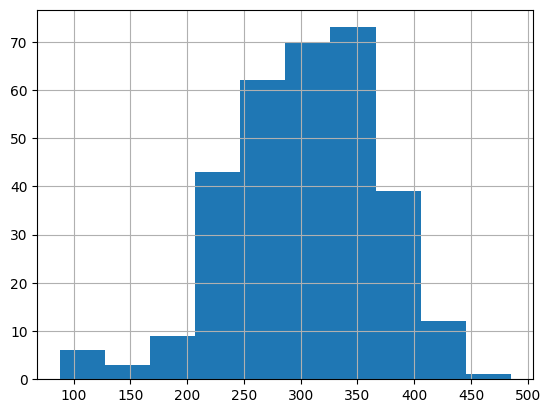

In [10]:
s_df["score"].hist(bins=10)

最後に、leader_flagとsupport_flagの確認をする。

In [12]:
print(s_df["leader_flag"].value_counts())
print(s_df["support_flag"].value_counts())

leader_flag
0    301
1     17
Name: count, dtype: int64
support_flag
0    314
1      4
Name: count, dtype: int64


### 以上で、生徒データの確認は完了。

次に、特定ペアのデータを確認する。

In [16]:
s_pair_df = pd.read_csv("student_pairs.csv")
print(f"students_pairs.csvの要素数：{len(s_pair_df)}")
s_pair_df.head()

students_pairs.csvの要素数：3


,student_id1,student_id2
0,118,189
1,72,50
2,314,233


### 以上で、データの確認は完了。続いて数理モデリングと実装に入る。

Pulpを取り込んで、数理モデルのインスタンスを生成。
今回は目的関数は定義しないが、次章で最大化問題を使うので、ここではLpMaximizeを使用する。

In [ ]:
import pulp

prob = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)  # 数理モデルのインスタンスを生成

ここから、冒頭の7つの要件を数理モデリングしていく。

-   【要件1】学年の全生徒をそれぞれ1つのクラスに割り当てる。
-   【要件2】各クラスの人数は39人以上、40人以下とする。　　318人の生徒、8つのクラス。
-   【要件3】各クラスの男子生徒、女子生徒の人数は20人以下とする。　男子生徒158人、女子生徒160人。
-   【要件4】各クラスの学力の平均点は学年平均の$\pm10$点とする。　500点満点で、学年平均303.6点。
-   【要件5】各クラスにリーダー気質の生徒を2人以上割り当てる。　　学年にリーダー気質は17人。
-   【要件6】特別な支援が必要な生徒は各クラスに1人以下とする。　　学年に特別な支援が必要な生徒は4人。
-   【要件7】特定ペアの生徒は同一クラスに割り当てない　　　　　　 学年に特定ペアは3組みいる。

### 【要件1】各生徒は1つのクラスに割り当てる
$$\sum_{c \in C} x_{s,c} = 1$$

生徒 s が、クラスc に割り当てられると、1になる。ある生徒sは、8クラス中1クラスのみ1になるので、8クラス分足し合わせて1になる。

では、生徒のリストSとクラスのリストCを作る。

In [18]:
S = s_df["student_id"].tolist()               # 生徒のリスト（データフレームから学籍番号をリストで取得。
C = ["A", "B", "C", "D", "E", "F", "G", "H"]  # クラスのリスト（自分で作成）

次に、生徒をどのクラスに割り当てるかを実装する。

生徒とクラスの考えられる全ペアのリストと、変数を定義する。

In [ ]:
SC = [(s, c) for s in S for c in C]  # 生徒 s とクラス c の全組み合わせのリストを作成。

x = pulp.LpVariable.dicts("x", SC, cat="Binary")
                            # 第一引数：変数名
                            # 第二引数：まとめて作る変数の添え字リスト（学籍番号, クラス名）
                            # 第三引数：変数のタイプ（Binaryなので、０か１かをとる）